In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as spla
import finite_lec as finite 
import timesteppers_lec as timesteppers 
import time

How does the matrix solve work? One way is using the LU factorization. We are trying to solve
$$ A\cdot x = b$$
for $x$. We can write
$$ A = L \cdot U$$
where $L$ is a lower-triangular matrix, and $U$ is an upper-triangular matrix.

In [8]:
def plot_2D(matrix):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

In [5]:
N = 20
grid = finite.UniformPeriodicGrid(N, 2*np.pi)
x = grid.values
IC = np.exp(-(x-np.pi)**2*8)

d = finite.CenteredFiniteDifference4(grid)

alpha = 0.05
ts = timesteppers.BackwardEuler(IC, d)
ts.step(0.01)

/Users/ericchen/opt/anaconda3/envs/446-1/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


/var/folders/88/6pmmpt1j1yl6ry0001r5f_lr0000gn/T/ipykernel_55218/3827991142.py:6: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


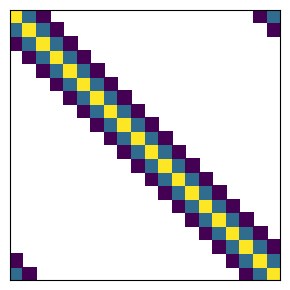

In [9]:
plot_2D(ts.LHS.toarray())

In [10]:
LU = spla.splu(ts.LHS.tocsc(), permc_spec='NATURAL') # 
np.allclose((LU.L * LU.U).toarray(), ts.LHS.toarray())

True

In [11]:
LU.U @ LU.L 

<20x20 sparse matrix of type '<class 'numpy.float64'>'
	with 400 stored elements in Compressed Sparse Column format>

Once doing this factorization, we solve
$$ U \cdot y = b$$
and then
$$ L \cdot x = y.$$

/var/folders/88/6pmmpt1j1yl6ry0001r5f_lr0000gn/T/ipykernel_55218/3827991142.py:6: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


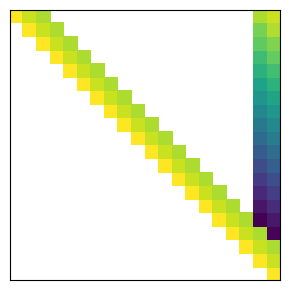

In [12]:
plot_2D(ts.LU.U.toarray()) # upper triangle

/var/folders/88/6pmmpt1j1yl6ry0001r5f_lr0000gn/T/ipykernel_55218/3827991142.py:6: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


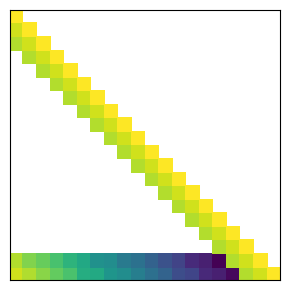

In [13]:
plot_2D(ts.LU.L.toarray()) # lower 
# from top to bottom 
# the last row is dense

## Crank-Nicolson

The Crank-Nicolson method is
$$u^{n} = u^{n-1} + \Delta t \frac{1}{2}\left(L(u^n) + L(u^{n-1})\right).$$
We can rewrite this as
$$(I - (\Delta t/2) L) u^{n} = (I + (\Delta t/2) L) u^{n-1}.$$

In [14]:
class CrankNicolson(timesteppers.ImplicitTimestepper):

    def _step(self, dt):
        if dt != self.dt:
            self.LHS = self.I - dt/2*self.L.matrix
            self.RHS = self.I + dt/2*self.L.matrix
            self.LU = spla.splu(self.LHS.tocsc(), permc_spec='NATURAL')
        self.dt = dt
        return self.LU.solve(self.RHS @ self.u)

Solve the diffusion equation
$$\partial_t u = \partial_x^2 u.$$

0.05


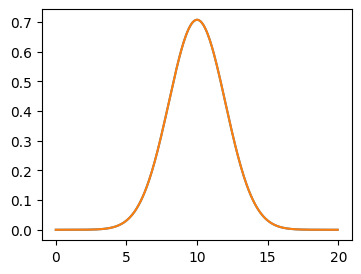

In [10]:
res = 400
grid = finite.UniformPeriodicGrid(res, 20)
x = grid.values
IC = np.exp(-(x-10)**2/4)
target = 1/np.sqrt(2)*np.exp(-(x-10)**2/8)

d2 = finite.CenteredFiniteSecondDifference(grid)

alpha = 1
ts = CrankNicolson(IC, d2)

dt = alpha*grid.dx
#dt = 1
print(dt)

ts.evolve(dt, 1)

plt.figure(figsize=(4,3))
plt.plot(x, ts.u)
plt.plot(x, target)